# DAMASK tutorial

- creating necessary inputs for damask
- defining the elastoplastic model (with powerlaw) for tensile test
- runing the damask jobs

here more option is given to the user to select from damask python package itself.

Author: Yang Bai

Date  : 23.02.2022

Update: 01.08.2022

## Importing libraries and creatign Project

In [1]:
from pyiron_continuum import Project
from damask import Rotation # this will be used in material configuration

/home/ybai/anaconda3/envs/pyiron/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-28 13:30:15,154 - pyiron_log - WARNING - pyiron found a 'dynamic' folder in the /home/ybai/pyiron/resources resource directory. These are no longer supported in pyiron_base >=0.7.0. They are replaced by Project.create_job_class() and Project.wrap_python_function().
2024-03-28 13:30:15,154 - pyiron_log - WARNING - pyiron found a 'templates' folder in the /home/ybai/pyiron/resources resource directory. These are no longer supported in pyiron_base >=0.7.0. They are replaced by Project.create_job_class() and Project.wrap_python_function().


### create a 'project' to manage all the configurations for a tensile test

In [2]:
pr = Project('RollingTest')
pr.remove_jobs(silently=True) # automatically delete the existing project folder

0it [00:00, ?it/s]


### Creating the Damask job

In [3]:
job = pr.create.job.ROLLING('damask_job')

#### for a damask job, one needs:
- geometry information(i.e., the mesh)
- material configuration(material.yaml)
- boundary conditions(i.e., loading.yaml)

### For material configuration
#### for elastoplastic material

In [4]:
elasticity = pr.continuum.damask.Elasticity(type= 'Hooke', C_11= 106.75e9,
                                   C_12= 60.41e9, C_44=28.34e9)
plasticity = pr.continuum.damask.Plasticity(type='phenopowerlaw',
                                            N_sl=[12],a_sl=[2.25],
                                            atol_xi=1.0,dot_gamma_0_sl=[0.001],
                                            h_0_sl_sl=[75.0e6],
                                            h_sl_sl=[1, 1, 1.4, 1.4, 1.4, 1.4, 1.4],
                                            n_sl=[20],
                                            output=['xi_sl'],
                                            xi_0_sl=[31.0e6],
                                            xi_inf_sl=[63.0e6]
                                           )


#### for material configuration, you need
- phase
- roation
- homogenization

In [5]:
grains = 16
grids = 16

phase = pr.continuum.damask.Phase(composition='Aluminum', lattice= 'cF',
                         output_list=['F', 'P', 'F_e', 'F_p', 'L_p', 'O'],
                         elasticity=elasticity,plasticity=plasticity)
rotation = pr.continuum.damask.Rotation(Rotation.from_random, grains)

homogenization = pr.continuum.damask.Homogenization(method='SX', 
                                                     parameters={'N_constituents': 1,
                                                                 "mechanical": {"type": "pass"}})

# now you can define your material.yaml configuration
material = pr.continuum.damask.Material([rotation],['Aluminum'], phase, homogenization)

# now you can save your material to your job
job.material = material

## For geometry information

In [6]:
grid = pr.continuum.damask.Grid.via_voronoi_tessellation(box_size=1.0e-5, grid_dim=grids, num_grains=grains)

# save the geometry information to your job
job.grid = grid 

# Define the 1st rolling test

In [7]:
reduction_height = 0.05
reduction_speed = 5.0e-2
reduction_outputs = 250
regrid_flag=False
damask_exe = '' # using default DAMASK_grid solver from PATH

# execute the rolling test
job.executeRolling(reduction_height,reduction_speed,reduction_outputs,regrid_flag,damask_exe)

working dir: /home/ybai/Projects/GitHub/pyiron_continuum/notebooks/RollingTest/damask_job_hdf5/damask_job
solver: {mechanical: spectral_basic}
loadstep:
- boundary_conditions:
    mechanical:
      P:
      - [0, x, x]
      - [x, x, x]
      - [x, x, x]
      dot_F:
      - [x, 0, 0]
      - [0, 0, 0]
      - [0, 0, -0.05]
  discretization: {t: 1.0, N: 250}
  f_out: 5
  f_restart: 5

Start the first rolling test ...
CMD= DAMASK_grid -g damask.vti -l load.yaml -m material.yaml > FirstRolling.log
First rolling test is done !


 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00


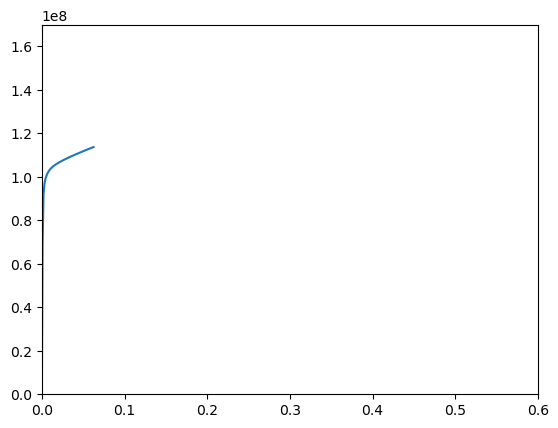

In [8]:
# show the result
job.postProcess() # do the postprocess
job.plotStressStrainCurve(0.0,0.60,0.0,1.7e8) # xmin,xmax, ymin,ymax

# Now, we can do the 2nd rolling test, with different parameters

In [9]:
reduction_height = 0.05
reduction_speed = 4.5e-2
reduction_outputs = 300
regrid_flag=True

# execute the rolling test
job.executeRolling(reduction_height,reduction_speed,reduction_outputs,regrid_flag,damask_exe)

------------------------
Start to regrid the geometry ...
initial RVE size:	 [1.e-05 1.e-05 1.e-05]
regridded RVE size:	 [1.05178679e-05 1.00000000e-05 9.50000000e-06]
initial grid seeds:	 [16 16 16]
regridded grid seeds:	 [18 17 16]
finding the nearest neighbors...
all the information are ready !
save regrid geometry to damask_regridded_increment_250.vti
Start the rolling-2 test ...
CMD= DAMASK_grid -g damask_regridded_increment_250.vti -l load_rolling2.yaml -m material.yaml > Rolling-2.log
Rolling-2 test is done !


 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00


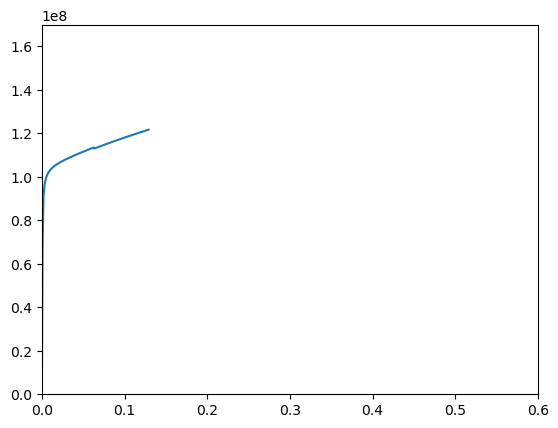

In [10]:
# show the result
job.postProcess() # do the postprocess
job.plotStressStrainCurve(0.0,0.60,0.0,1.7e8) # xmin,xmax, ymin,ymax

In [11]:
# List out all the hdf5 results file
print(job.ResultsFile)

['damask_load_material.hdf5', 'damask_regridded_increment_250_load_rolling2_material.hdf5']


In [12]:
job.write_openphase_config(step=1000, dt=1.0e-5, nuclei=4)

min size is: 9.500000000000062e-06
